In [1]:
"""
#Trains a ResNet on the CIFAR10 dataset.

ResNet v1:
[Deep Residual Learning for Image Recognition
](https://arxiv.org/pdf/1512.03385.pdf)

ResNet v2:
[Identity Mappings in Deep Residual Networks
](https://arxiv.org/pdf/1603.05027.pdf)


Model|n|200-epoch accuracy|Original paper accuracy |sec/epoch GTX1080Ti
:------------|--:|-------:|-----------------------:|---:
ResNet20   v1|  3| 92.16 %|                 91.25 %|35
ResNet32   v1|  5| 92.46 %|                 92.49 %|50
ResNet44   v1|  7| 92.50 %|                 92.83 %|70
ResNet56   v1|  9| 92.71 %|                 93.03 %|90
ResNet110  v1| 18| 92.65 %|            93.39+-.16 %|165
ResNet164  v1| 27|     - %|                 94.07 %|  -
ResNet1001 v1|N/A|     - %|                 92.39 %|  -

&nbsp;

Model|n|200-epoch accuracy|Original paper accuracy |sec/epoch GTX1080Ti
:------------|--:|-------:|-----------------------:|---:
ResNet20   v2|  2|     - %|                     - %|---
ResNet32   v2|N/A| NA    %|            NA         %| NA
ResNet44   v2|N/A| NA    %|            NA         %| NA
ResNet56   v2|  6| 93.01 %|            NA         %|100
ResNet110  v2| 12| 93.15 %|            93.63      %|180
ResNet164  v2| 18|     - %|            94.54      %|  -
ResNet1001 v2|111|     - %|            95.08+-.14 %|  -
"""

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 120
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# The data, split between train and test sets:
x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')
x_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255


# # Load the CIFAR10 data.
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Input image dimensions.
input_shape = x_train.shape[1:]

# # Normalize data.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# # Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


x_train.shape, y_train.shape, x_test.shape, y_test.shape


Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [2]:
model_type

'ResNet29v2'

In [3]:
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [4]:
# epochs = 120


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out-size = (None, 8, 8, 256)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
# print(model_type)


Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [3]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,steps_per_epoch=int(1500/4),
                        callbacks=callbacks)



Using real-time data augmentation.
Epoch 1/120
Learning rate:  0.001
375/375 [==============================] - 34s 89ms/step - loss: 2.0231 - acc: 0.4488 - val_loss: 1.9742 - val_acc: 0.4512

Epoch 00001: val_acc improved from -inf to 0.45120, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_ResNet29v2_model.001.h5
Epoch 2/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 1.5501 - acc: 0.5942 - val_loss: 1.6276 - val_acc: 0.5580

Epoch 00002: val_acc improved from 0.45120 to 0.55800, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_ResNet29v2_model.002.h5
Epoch 3/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 1.3303 - acc: 0.6589 - val_loss: 1.9159 - val_acc: 0.5146

Epoch 00003: val_acc did not improve from 0.55800
Epoch 4/120
Learning rate:  0.001
375/375 [==============================] - 25s 65ms/step - loss: 1.1735 - acc: 0.7105 

375/375 [==============================] - 25s 66ms/step - loss: 0.5417 - acc: 0.8935 - val_loss: 0.8371 - val_acc: 0.8049

Epoch 00032: val_acc did not improve from 0.84760
Epoch 33/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5276 - acc: 0.8969 - val_loss: 0.8034 - val_acc: 0.8144

Epoch 00033: val_acc did not improve from 0.84760
Epoch 34/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5283 - acc: 0.8992 - val_loss: 0.7692 - val_acc: 0.8251

Epoch 00034: val_acc did not improve from 0.84760
Epoch 35/120
Learning rate:  0.001
375/375 [==============================] - 25s 65ms/step - loss: 0.5181 - acc: 0.9022 - val_loss: 0.7207 - val_acc: 0.8383

Epoch 00035: val_acc did not improve from 0.84760
Epoch 36/120
Learning rate:  0.001
375/375 [==============================] - 24s 65ms/step - loss: 0.5216 - acc: 0.9002 - val_loss: 0.8878 - val_acc: 0.7994

Epoch 00036: val_acc did not improve fro

Epoch 104/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2076 - acc: 0.9893 - val_loss: 0.5060 - val_acc: 0.9166

Epoch 00104: val_acc did not improve from 0.91980
Epoch 105/120
Learning rate:  0.0001
375/375 [==============================] - 24s 65ms/step - loss: 0.2068 - acc: 0.9885 - val_loss: 0.5086 - val_acc: 0.9162

Epoch 00105: val_acc did not improve from 0.91980
Epoch 106/120
Learning rate:  0.0001
375/375 [==============================] - 24s 65ms/step - loss: 0.2033 - acc: 0.9888 - val_loss: 0.5114 - val_acc: 0.9159

Epoch 00106: val_acc did not improve from 0.91980
Epoch 107/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2020 - acc: 0.9891 - val_loss: 0.5222 - val_acc: 0.9141

Epoch 00107: val_acc did not improve from 0.91980
Epoch 108/120
Learning rate:  0.0001
375/375 [==============================] - 25s 66ms/step - loss: 0.2007 - acc: 0.9891 - val_loss: 0.5005 - val_acc: 0.9

In [4]:
model.history.history

{'acc': [0.4488333333333333,
  0.5942817817817818,
  0.6588463463264582,
  0.7104813146479814,
  0.7433683683484803,
  0.7656406406605287,
  0.7771312980044075,
  0.7963588588787469,
  0.8051801802000683,
  0.8135844177709726,
  0.8228436769705675,
  0.8301426426625308,
  0.8394853186122091,
  0.8415498831966618,
  0.8448031364896912,
  0.8500583917051703,
  0.8566691691890572,
  0.8581081081081081,
  0.8672213880746095,
  0.8644269269269269,
  0.869411077724523,
  0.8730814147083052,
  0.8739364364563246,
  0.8773982315648983,
  0.8806041666666666,
  0.8813813814211576,
  0.8868034701169154,
  0.8863238238238238,
  0.8898481815148482,
  0.8934976643707738,
  0.8940815815815816,
  0.8935602268935602,
  0.8969177511043058,
  0.8992534200668654,
  0.90219386056697,
  0.9001918585053038,
  0.8997122122321003,
  0.9054888221554889,
  0.9046129462398368,
  0.9053636970104756,
  0.9066983650118102,
  0.9085335335335335,
  0.9076159492428397,
  0.910472972972973,
  0.9129754754754755,
  0.909

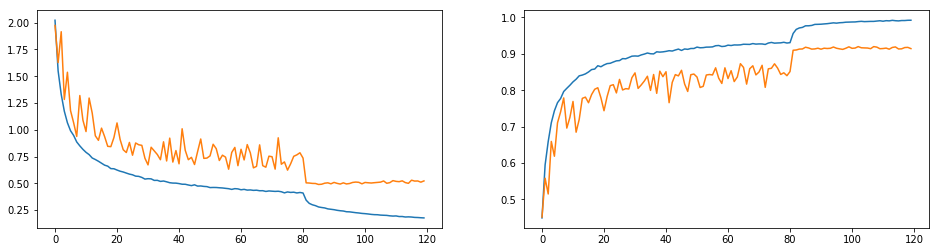

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(range(120),model.history.history['loss'], range(120),model.history.history['val_loss'])
ax[1].plot(range(120),model.history.history['acc'], range(120),model.history.history['val_acc'])

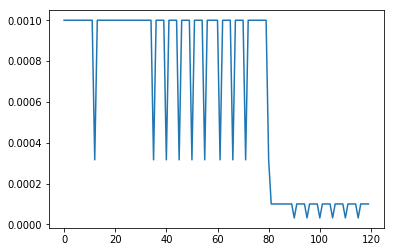

In [7]:
plt.plot(model.history.history['lr'])

In [8]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


10000/10000 [==============================] - 3s 267us/step
Test loss: 0.5226242788314819
Test accuracy: 0.9143
